# Face Expression Recognition using VGGNet

## Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.data import ConcatDataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting up the GPU

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Creating Dataset

In [8]:
class ImagesDataset(Dataset):

    def __init__(self, root_dir, transform=None, ratio=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.ratio = ratio
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for c in self.classes:
            for img in os.listdir(os.path.join(root_dir, c)):
                sample = np.random.uniform()
                if sample <= self.ratio:
                    self.images.append(img)
                    self.labels.append(self.class_to_idx[c])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.classes[self.labels[idx]], self.images[idx])
        image = Image.open(img_name)
        label = self.labels[idx]

        PIL_transform = transforms.Compose([transforms.PILToTensor()])
        image = PIL_transform(image)
        image = image.float()

        # Apply additional transform 
        if self.transform:
            image = self.transform(image)

        return image, label

## Preprocessing the Images

### Normalizing the Images and Data Augmentation

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [10]:
flip_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [11]:
rotate_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=20),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

In [12]:
translate_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Normalize((0, 0, 0), (255, 255, 255)),
])

## Loading the Images

### Building the Dataset

In [13]:
# modify the root path based on your environment
root_dir = '/kaggle/input/face-emotion-dataset/Face_Emotion_Dataset/TRAIN'
real_dataset = ImagesDataset(root_dir, transform=transform)
flipped_dataset = ImagesDataset(root_dir, transform=flip_transform, ratio=0.33)
rotated_dataset = ImagesDataset(root_dir, transform=rotate_transform, ratio=0.33)
translated_dataset = ImagesDataset(root_dir, transform=translate_transform, ratio=0.33)
images_dataset = ConcatDataset([real_dataset, flipped_dataset, rotated_dataset, translated_dataset])

### Train-Test Split

In [14]:
test_ratio = 0.2
train_size = int((1 - test_ratio) * len(images_dataset))
test_size = len(images_dataset) - train_size
train_dataset, test_dataset = random_split(images_dataset, [train_size, test_size])

### Creating the DataLoader

In [15]:
batch_size = 400
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


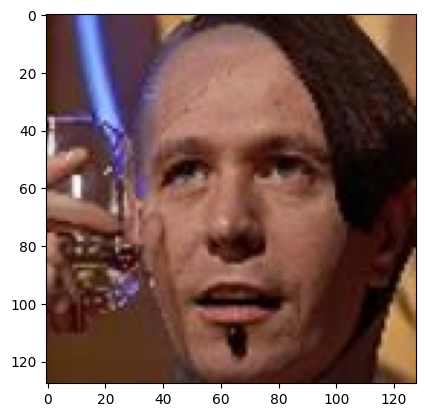

In [16]:
image = images_dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
plt.show()

## Implementing the Model

In [17]:
# Defined based on keras.layers.GaussianDropout implementation
class GaussianDropout(nn.Module):

    def __init__(self, rate: float):
        super().__init__()
        self.t_mean = torch.ones((0,))
        self.shape = ()
        self.rate = rate

    def forward(self, x):
        if self.training and self.rate > 0.:
            if self.t_mean.shape != x.shape:
                self.t_mean = torch.ones_like(input=x
                                              , dtype=x.dtype
                                              , device=x.device)
            std = self.rate / (1 - self.rate)
            t_gaussian_noise = torch.normal(self.t_mean, std)
            x = x.mul(t_gaussian_noise)
        return x

In [18]:
class VGGNet(nn.Module):
    def __init__(self, in_channels, num_classes=8):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            GaussianDropout(rate=0.2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            GaussianDropout(rate=0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same', stride=(1, 1)), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            GaussianDropout(rate=0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            GaussianDropout(rate=0.2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding='same', stride=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            GaussianDropout(rate=0.2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
         nn.Flatten(),
            
         nn.Linear(2048, 1024),
         nn.ReLU(),
         nn.Dropout(p=0.5),
            
         nn.Linear(1024, 1024),
         nn.ReLU(),
         nn.Dropout(p=0.5),
            
         nn.Linear(1024, num_classes),
         nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Training the Model

In [19]:
model = VGGNet(in_channels=3)
model.to(device)

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): GaussianDropout()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): GaussianDropout()
    (16

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
# Parameters are set based on the 'CNN-based Facial Affect Analysis on Mobile Devices' paper
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=epsilon)

In [22]:
def train_model(model, data_loader, criterion, optimizer, num_epochs):

    model.train()

    loss_vals = []
    num_preds = []
    cor_preds = []

    for epoch in tqdm.tqdm(range(num_epochs)):

        epoch_loss = []
        epoch_num_preds = 0
        epoch_cor_preds = 0

        for images, labels in data_loader:
            
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)

            loss = criterion(preds, labels)

            optimizer.zero_grad()

            loss.backward()
            epoch_loss.append(loss.item())

            optimizer.step()
            
            _, predicted = torch.max(preds, 1)

            epoch_num_preds += len(labels)
            epoch_cor_preds += (predicted == labels).sum().item()

        loss_vals.append(np.mean(epoch_loss))
        num_preds.append(epoch_num_preds)
        cor_preds.append(epoch_cor_preds)
        print(f'Epoch:{epoch+1}, Loss:{np.mean(epoch_loss):.4f}, Accuracy:{(epoch_cor_preds/epoch_num_preds) * 100:.2f}')

    return loss_vals, num_preds, cor_preds

In [23]:
def plot_training_summary(loss_vals, num_preds, cor_preds, epochs):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss")

    plt.subplot(1, 2, 2)
    plt.plot(np.linspace(1, epochs, epochs).astype(int), np.array(cor_preds) / np.array(num_preds))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training accuracy")

    plt.tight_layout()
    plt.show()

In [24]:
# Number of epochs are set as in the paper
num_epochs = 24
loss_vals_training, num_preds_training, cor_preds_training = train_model(model, train_dataloader, criterion, optimizer, num_epochs)

  4%|▍         | 1/24 [01:37<37:16, 97.24s/it]

Epoch:1, Loss:2.0719, Accuracy:15.74


  8%|▊         | 2/24 [02:17<23:17, 63.52s/it]

Epoch:2, Loss:2.0021, Accuracy:24.29


 12%|█▎        | 3/24 [02:57<18:27, 52.74s/it]

Epoch:3, Loss:1.9451, Accuracy:31.43


 17%|█▋        | 4/24 [03:37<15:58, 47.93s/it]

Epoch:4, Loss:1.8903, Accuracy:37.22


 21%|██        | 5/24 [04:18<14:19, 45.23s/it]

Epoch:5, Loss:1.8502, Accuracy:41.32


 25%|██▌       | 6/24 [04:58<13:02, 43.45s/it]

Epoch:6, Loss:1.8314, Accuracy:43.37


 29%|██▉       | 7/24 [05:38<12:03, 42.56s/it]

Epoch:7, Loss:1.8162, Accuracy:44.99


 33%|███▎      | 8/24 [06:19<11:09, 41.85s/it]

Epoch:8, Loss:1.8086, Accuracy:45.87


 38%|███▊      | 9/24 [06:59<10:21, 41.43s/it]

Epoch:9, Loss:1.7956, Accuracy:47.09


 42%|████▏     | 10/24 [07:40<09:35, 41.11s/it]

Epoch:10, Loss:1.7883, Accuracy:47.90


 46%|████▌     | 11/24 [08:20<08:52, 40.94s/it]

Epoch:11, Loss:1.7811, Accuracy:48.51


 50%|█████     | 12/24 [09:00<08:08, 40.75s/it]

Epoch:12, Loss:1.7538, Accuracy:51.51


 54%|█████▍    | 13/24 [09:41<07:28, 40.78s/it]

Epoch:13, Loss:1.7578, Accuracy:50.87


 58%|█████▊    | 14/24 [10:22<06:48, 40.87s/it]

Epoch:14, Loss:1.7431, Accuracy:52.53


 62%|██████▎   | 15/24 [11:02<06:05, 40.64s/it]

Epoch:15, Loss:1.7300, Accuracy:53.91


 67%|██████▋   | 16/24 [11:43<05:25, 40.63s/it]

Epoch:16, Loss:1.7191, Accuracy:55.04


 71%|███████   | 17/24 [12:24<04:45, 40.73s/it]

Epoch:17, Loss:1.7210, Accuracy:54.78


 75%|███████▌  | 18/24 [13:05<04:04, 40.78s/it]

Epoch:18, Loss:1.7239, Accuracy:54.62


 79%|███████▉  | 19/24 [13:46<03:23, 40.77s/it]

Epoch:19, Loss:1.7039, Accuracy:56.50


 83%|████████▎ | 20/24 [14:27<02:43, 40.88s/it]

Epoch:20, Loss:1.7030, Accuracy:56.85


 88%|████████▊ | 21/24 [15:07<02:02, 40.79s/it]

Epoch:21, Loss:1.6934, Accuracy:57.62


 92%|█████████▏| 22/24 [15:49<01:22, 41.02s/it]

Epoch:22, Loss:1.6848, Accuracy:58.49


 96%|█████████▌| 23/24 [16:31<00:41, 41.21s/it]

Epoch:23, Loss:1.6803, Accuracy:59.08


100%|██████████| 24/24 [17:11<00:00, 43.00s/it]

Epoch:24, Loss:1.6800, Accuracy:58.97


In [25]:
torch.save(model, 'VGGNet.pth')

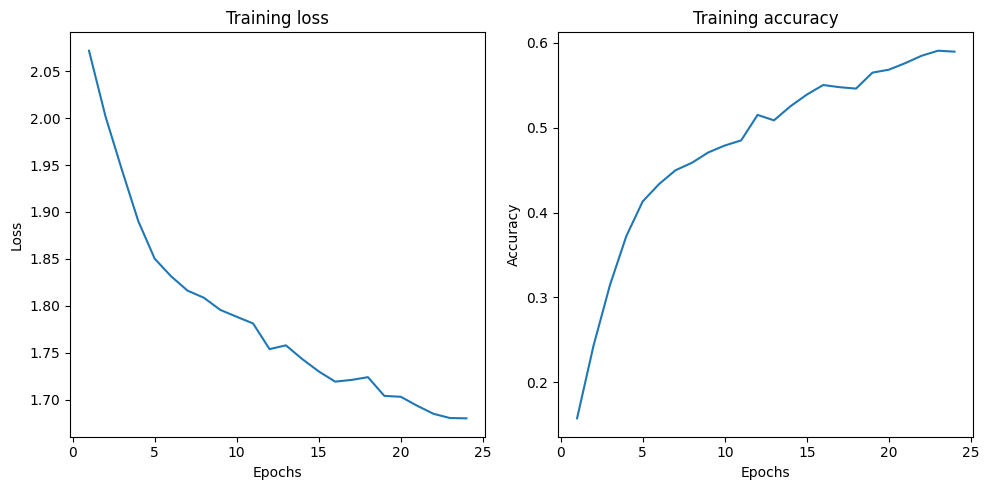

In [26]:
plot_training_summary(loss_vals_training, num_preds_training, cor_preds_training, num_epochs)

## Evaluating the Model

In [27]:
def evaluate_model(model, data_loader, criterion):
    model.eval()

    test_loss = 0.0
    num_preds = 0
    true_preds = 0

    eval_labels = []
    preds_labels = []
    loss_val = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            loss = criterion(preds, labels)
            loss_val.append(loss.item())

            _, predicted = torch.max(preds, 1)
            num_preds += len(labels)
            true_preds += (predicted == labels).sum().item()

            eval_labels.append(labels.cpu().numpy())
            preds_labels.append(preds.cpu().numpy())
            
    test_loss = np.mean(loss_val)
    eval_labels = np.concatenate(eval_labels)
    preds_labels = np.concatenate(preds_labels)

    return num_preds, true_preds, eval_labels, preds_labels, test_loss

### Accuracy

In [28]:
num_preds_test, true_preds_test, labels_test, preds_test, loss = evaluate_model(model, test_dataloader, criterion)

print("Test accuracy: {:.2f}%".format(true_preds_test / num_preds_test * 100))
print("Test loss: {:.4f}".format(loss))

100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

Test accuracy: 56.08%
Test loss: 1.7118


### ROC Curve

In [29]:
def plot_roc_curve(labels, preds):
    fpr = dict()    # False Positive Rate
    tpr = dict()    # True Positive Rate
    roc_auc = dict()   # Area under the ROC Curve

    plt.figure(figsize=(10, 8))
    
    class_names = real_dataset.classes

    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(labels == i, preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for each class')
    plt.legend(loc="lower right")
    plt.show()

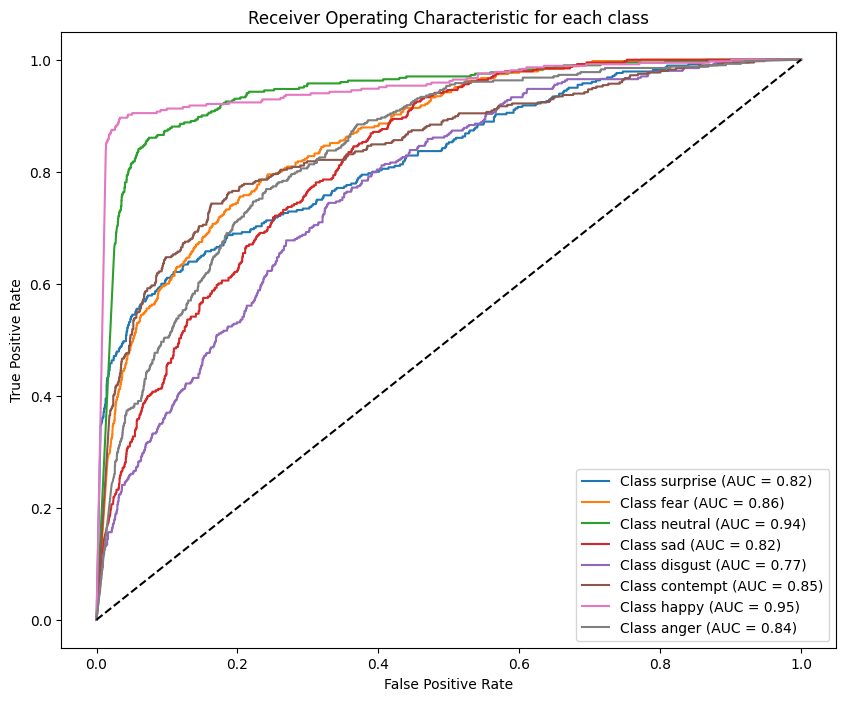

In [30]:
plot_roc_curve(labels_test, preds_test)

### F1, Precision, Recall

In [31]:
from sklearn.metrics import classification_report
# Suprised, Afraid, Neutral, Sad, Disgusted, Contempt, Happy and Angry
class_names = ['Su', 'Af', 'N', 'Sa', 'D', 'C', 'H', 'An']
preds_test_ = np.argmax(preds_test, axis=1)
class_report = classification_report(labels_test, preds_test_, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

          Su       0.72      0.47      0.57       380
          Af       0.60      0.50      0.55       430
           N       0.66      0.84      0.74       402
          Sa       0.33      0.59      0.42       388
           D       0.47      0.25      0.32       403
           C       0.59      0.54      0.56       397
           H       0.78      0.90      0.83       367
          An       0.47      0.44      0.46       407

    accuracy                           0.56      3174
   macro avg       0.58      0.56      0.56      3174
weighted avg       0.58      0.56      0.55      3174



### Confusion Matrix

In [32]:
def plot_confusion_matrix(labels, preds, classes):
        pred_labels = np.argmax(preds, axis=1)
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        cm = confusion_matrix(labels, pred_labels)
        
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        plt.show()

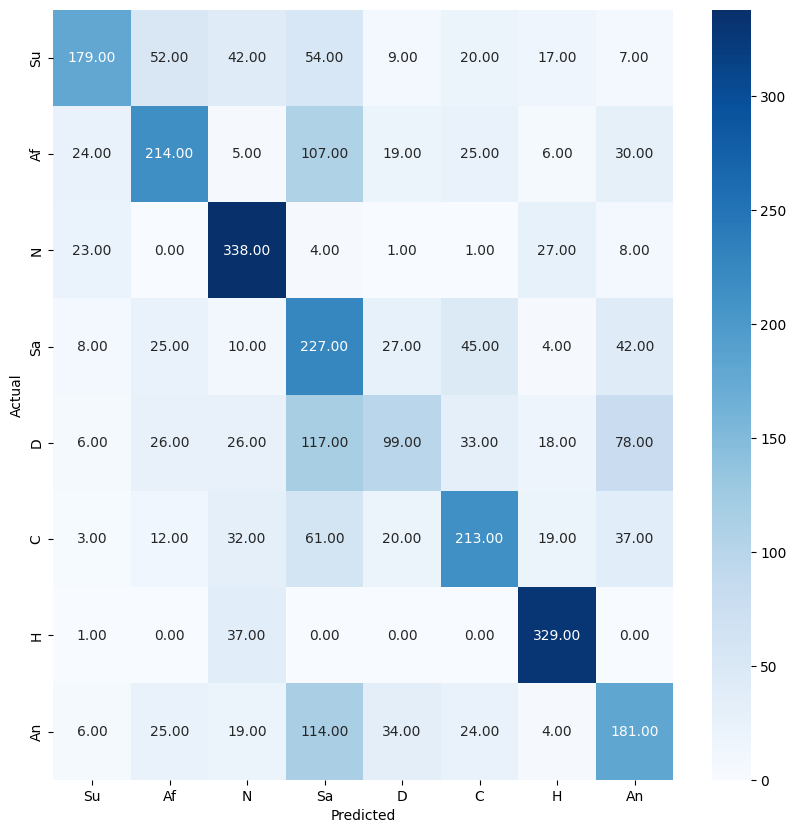

In [33]:
# Suprised, Afraid, Neutral, Sad, Disgusted, Contempt, Happy and Angry
class_names = ['Su', 'Af', 'N', 'Sa', 'D', 'C', 'H', 'An']
plot_confusion_matrix(labels_test, preds_test, class_names)

# Fine-Tuning

### Building the Dataset

In [34]:
# modify the root path based on your environment
root_tune_data_dir = '/kaggle/input/face-emotion-dataset/Face_Emotion_Dataset/TUNE'
fine_tune_dataset = ImagesDataset(root_tune_data_dir, transform=transform)

### Creating the DataLoader

In [35]:
batch_size = 400
fine_tune_dataloader = DataLoader(fine_tune_dataset, batch_size=batch_size, shuffle=True)

### Loading pre-trained model

In [36]:
pretrained_model = torch.load('VGGNet.pth')
pretrained_model.to(device)

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): GaussianDropout()
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): GaussianDropout()
    (16

### Fine-Tune model

In [37]:
class FineTuner:
    def freeze_layers(self, up_to_layer, model):
        # Freeze layers 
        for name, param in model.named_parameters():
            if name.startswith(up_to_layer):
                break
            param.requires_grad = False
        return model
            
    def modify_last_layer(self, new_num_classes, model):
        new_last_layer =  nn.Linear(1024, new_num_classes)
        model.classifier[-1] = new_last_layer.to(device)
        return model

In [38]:
fine_tuner = FineTuner()
fine_tuner= fine_tuner.freeze_layers('features', pretrained_model)    # Freeze cnn-blocks and fine-tune fully sonnected layers

In [39]:
finetuning_criterion = nn.CrossEntropyLoss()

In [40]:
finetuning_optimizer = optim.Adam(fine_tuner.parameters(), lr=0.0001, betas=(0.5, beta2), eps=epsilon)

In [41]:
loss_vals, num_preds, cor_preds = train_model(fine_tuner, fine_tune_dataloader, finetuning_criterion, finetuning_optimizer, num_epochs=16)

  0%|          | 0/16 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  6%|▋         | 1/16 [00:14<03:31, 14.13s/it]

Epoch:1, Loss:1.8401, Accuracy:42.81


 12%|█▎        | 2/16 [00:18<01:55,  8.27s/it]

Epoch:2, Loss:1.8497, Accuracy:41.69


 19%|█▉        | 3/16 [00:22<01:23,  6.43s/it]

Epoch:3, Loss:1.8258, Accuracy:44.38


 25%|██▌       | 4/16 [00:26<01:06,  5.54s/it]

Epoch:4, Loss:1.8260, Accuracy:44.69


 31%|███▏      | 5/16 [00:30<00:55,  5.06s/it]

Epoch:5, Loss:1.8276, Accuracy:44.12


 38%|███▊      | 6/16 [00:35<00:47,  4.77s/it]

Epoch:6, Loss:1.8277, Accuracy:44.38


 44%|████▍     | 7/16 [00:39<00:41,  4.59s/it]

Epoch:7, Loss:1.8213, Accuracy:44.62


 50%|█████     | 8/16 [00:43<00:36,  4.51s/it]

Epoch:8, Loss:1.8067, Accuracy:46.44


 56%|█████▋    | 9/16 [00:48<00:31,  4.52s/it]

Epoch:9, Loss:1.8141, Accuracy:45.31


 62%|██████▎   | 10/16 [00:52<00:27,  4.51s/it]

Epoch:10, Loss:1.8138, Accuracy:45.75


 69%|██████▉   | 11/16 [00:56<00:22,  4.44s/it]

Epoch:11, Loss:1.8035, Accuracy:46.62


 75%|███████▌  | 12/16 [01:01<00:17,  4.36s/it]

Epoch:12, Loss:1.8100, Accuracy:45.88


 81%|████████▏ | 13/16 [01:05<00:13,  4.34s/it]

Epoch:13, Loss:1.7963, Accuracy:47.19


 88%|████████▊ | 14/16 [01:09<00:08,  4.28s/it]

Epoch:14, Loss:1.8019, Accuracy:46.25


 94%|█████████▍| 15/16 [01:13<00:04,  4.24s/it]

Epoch:15, Loss:1.7959, Accuracy:47.19


100%|██████████| 16/16 [01:17<00:00,  4.87s/it]

Epoch:16, Loss:1.7891, Accuracy:48.19


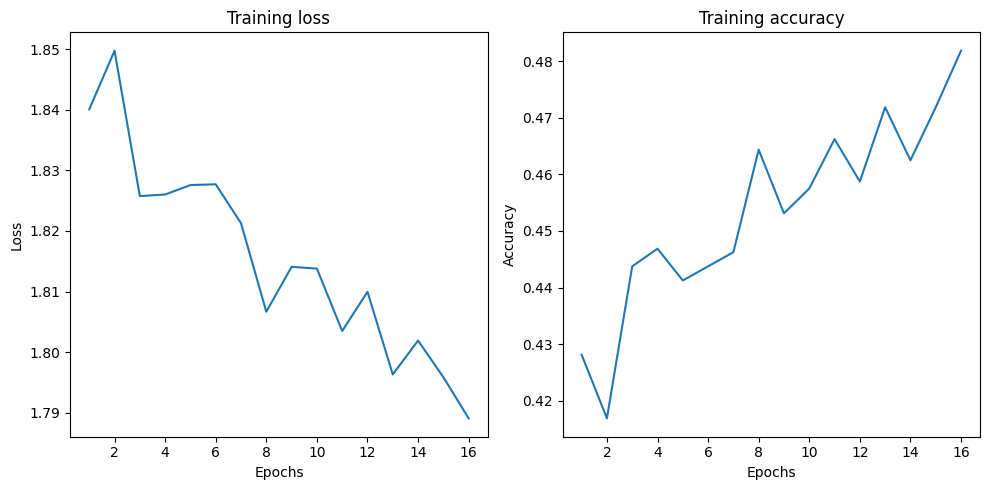

In [42]:
plot_training_summary(loss_vals, num_preds, cor_preds, 16)

### Accuracy on testdataset

In [43]:
num_preds, true_preds, labels_tune, preds_tune, loss = evaluate_model(fine_tuner, test_dataloader, criterion)

print("Test accuracy: {:.2f}%".format((true_preds / num_preds) * 100))
print("Test loss: {:.4f}".format(loss))

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]

Test accuracy: 56.49%
Test loss: 1.7074


### ROC Curve

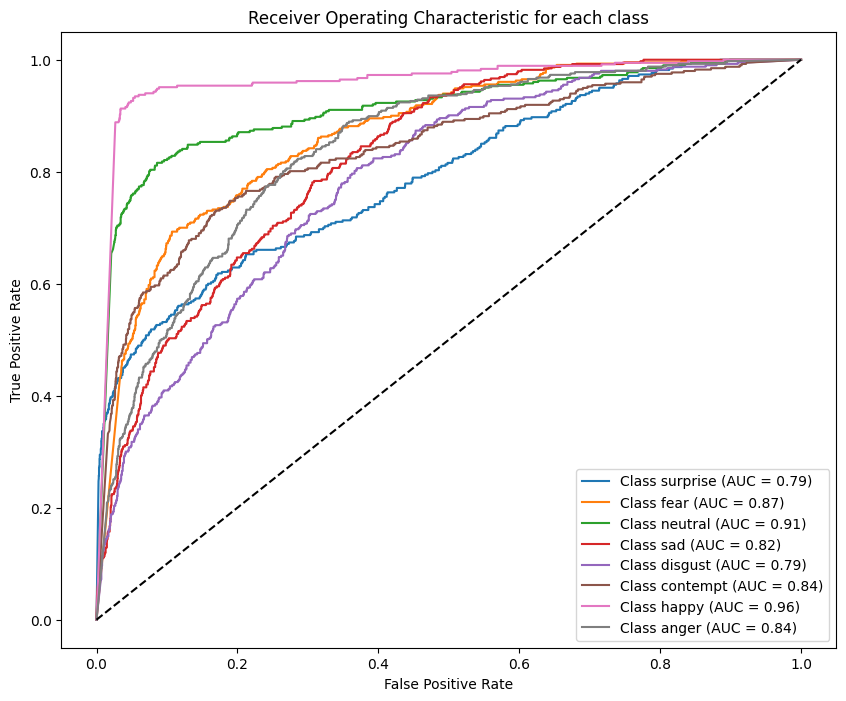

In [44]:
plot_roc_curve(labels_tune, preds_tune)

### F1, Precision, Recall

In [45]:
class_names = ['Su', 'Af', 'N', 'Sa', 'D', 'C', 'H', 'An']
preds_tune_ = np.argmax(preds_tune, axis=1)
class_report = classification_report(labels_tune, preds_tune_, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

          Su       0.73      0.39      0.51       380
          Af       0.54      0.63      0.58       430
           N       0.61      0.79      0.69       402
          Sa       0.42      0.48      0.45       388
           D       0.48      0.31      0.38       403
           C       0.60      0.55      0.57       397
           H       0.69      0.93      0.79       367
          An       0.50      0.44      0.47       407

    accuracy                           0.56      3174
   macro avg       0.57      0.57      0.55      3174
weighted avg       0.57      0.56      0.55      3174



### Confusion Matrix

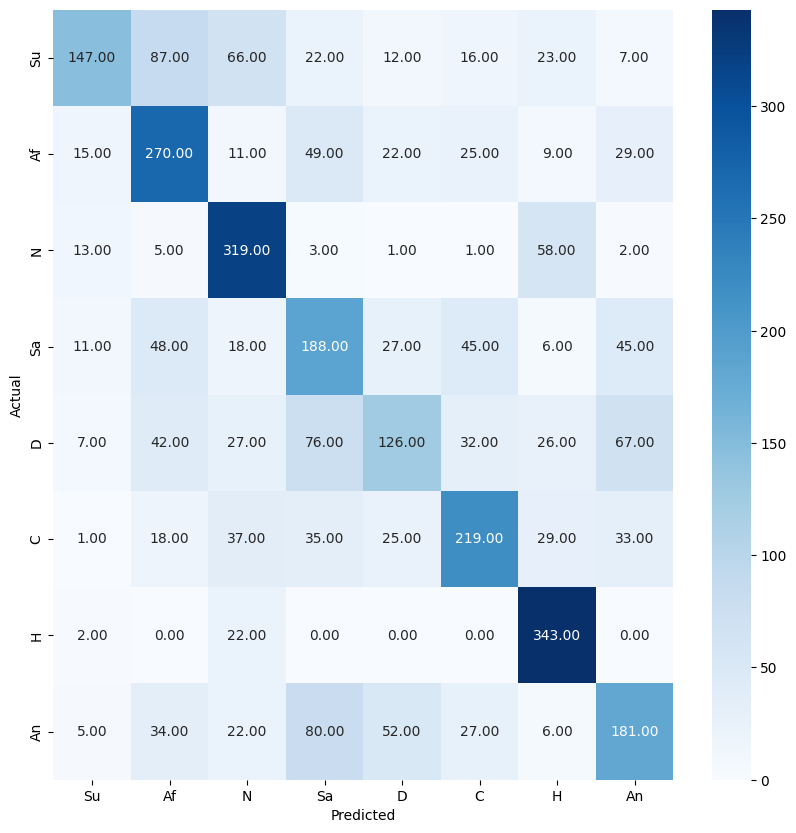

In [46]:
# Suprised, Afraid, Neutral, Sad, Disgusted, Contempt, Happy and Angry
class_names = ['Su', 'Af', 'N', 'Sa', 'D', 'C', 'H', 'An']
plot_confusion_matrix(labels_tune, preds_tune, class_names)